In [40]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import make_pipeline

from category_encoders import OneHotEncoder

In [18]:
# read the data sets
df = pd.read_csv('../data/clean_HR_Analytics2.csv')

#### Split

In [19]:
# vertical split
target = "Attrition"
X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Build

In [22]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    # stan
    RandomForestClassifier(random_state=42)
)

In [32]:
params = {
    "randomforestclassifier__n_estimators": range(50, 100, 5),
    "randomforestclassifier__max_depth": range(10, 50, 5)
}

In [33]:
model = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 5),
                         'randomforestclassifier__n_estimators': range(50, 100, 5)},
             verbose=1)

In [34]:
# Train model
model.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 5),
                         'randomforestclassifier__n_estimators': range(50, 100, 5)},
             verbose=1)

In [26]:
cv_result = pd.DataFrame(model.cv_results_)
cv_result.head(6)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.432362,0.012688,0.061249,0.008579,10,50,"{'randomforestclassifier__max_depth': 10, 'ran...",0.843220,0.863830,0.855319,0.851064,0.859574,0.854602,0.007106,7
1,0.672977,0.129653,0.083805,0.019418,10,60,"{'randomforestclassifier__max_depth': 10, 'ran...",0.851695,0.863830,0.851064,0.846809,0.863830,0.855445,0.007049,6
2,0.605668,0.093148,0.069232,0.008587,10,70,"{'randomforestclassifier__max_depth': 10, 'ran...",0.851695,0.859574,0.846809,0.851064,0.872340,0.856296,0.009019,4
3,0.597649,0.065750,0.079654,0.021163,10,80,"{'randomforestclassifier__max_depth': 10, 'ran...",0.847458,0.859574,0.851064,0.851064,0.868085,0.855449,0.007470,5
4,0.684989,0.042908,0.070327,0.010504,10,90,"{'randomforestclassifier__max_depth': 10, 'ran...",0.847458,0.855319,0.855319,0.842553,0.872340,0.854598,0.010118,8
5,0.551488,0.142283,0.072738,0.016592,20,50,"{'randomforestclassifier__max_depth': 20, 'ran...",0.855932,0.876596,0.851064,0.851064,0.851064,0.857144,0.009907,1


In [38]:
# Extract the best hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__n_estimators': 55}

#### Evaluate

In [39]:
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print("Training Accuracy: ", round(train_acc, 2))
print("Test Accuracy: ", round(test_acc, 2))

Training Accuracy:  1.0
Test Accuracy:  0.86


##### Plot Confusion Matrix

In [29]:
# generate the confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[250,   5],
       [ 35,   4]])

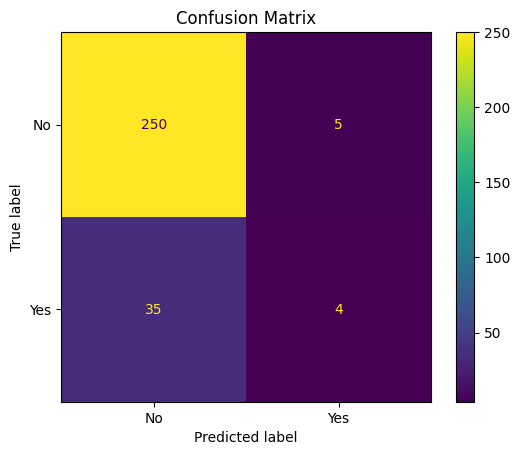

In [30]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# plot the confusion matrix
cm_display.plot() 
plt.title("Confusion Matrix");
plt.savefig('../reports/confusion_matrix_RF.jpg')

#### Communicate

In [18]:
# get feature names
features = model.best_estimator_.named_steps["onehotencoder"].get_feature_names_out()
# Extract the importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# create a series
features_imp = pd.Series(importances, index=features).sort_values()

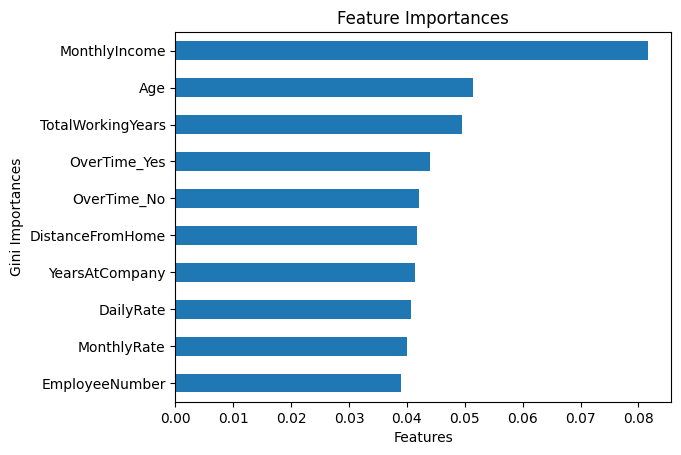

In [62]:
features_imp.tail(10).plot(kind="barh")
plt.xlabel("Features")
plt.ylabel("Gini Importances")
plt.title("Feature Importances");

#### Save the Model

In [12]:
import joblib
timestamp = pd.Timestamp.now().replace(microsecond=0).isoformat()
file_path = os.path.join('../models', f'{timestamp}_RF.joblib')
with open(file_path, 'wb') as f:
    pickle.dump(model, f)